# **Melbourne House Price prediction**

## **Importing** **libraries** **bold text**

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV





plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
       "axes",
       labelweight = "bold",
       labelsize = "large",
       titleweight = "bold",
       titlesize = 14,
       titlepad = 10,
       )

warnings.filterwarnings('ignore')

##Installing and importing **lazypredict** (A tool for model performance predictions)

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor

## Uploading the Melbourne dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Melbourne_housing_FULL.csv to Melbourne_housing_FULL (1).csv


In [ ]:
import io

dataset = pd.read_csv(io.BytesIO(uploaded['Melbourne_housing_FULL.csv']))

List of categorical cols

In [ ]:
dataset.select_dtypes(include = ["object"]).columns

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')

In [ ]:
councilarea = dataset["CouncilArea"].unique()
councilarea

array(['Yarra City Council', 'Moonee Valley City Council',
       'Port Phillip City Council', 'Darebin City Council',
       'Hobsons Bay City Council', 'Stonnington City Council',
       'Boroondara City Council', 'Monash City Council',
       'Glen Eira City Council', 'Whitehorse City Council',
       'Maribyrnong City Council', 'Bayside City Council',
       'Moreland City Council', 'Manningham City Council',
       'Melbourne City Council', 'Banyule City Council',
       'Brimbank City Council', 'Kingston City Council',
       'Hume City Council', 'Knox City Council', 'Maroondah City Council',
       'Casey City Council', 'Melton City Council',
       'Greater Dandenong City Council', 'Nillumbik Shire Council',
       'Cardinia Shire Council', 'Whittlesea City Council',
       'Frankston City Council', 'Macedon Ranges Shire Council',
       'Yarra Ranges Shire Council', 'Wyndham City Council',
       'Moorabool Shire Council', 'Mitchell Shire Council', nan],
      dtype=object)

## We'll firstly correct our dataset by dropping unecessary columns and then impute it by filing NaN values after this we'll normalize the dataset

The correct function:
1.   Import the dataset
2.   Transform the "Date" column to a "datetime" category
3.   Add a column for years of Selling (extracted from the "Date" column)
4.   Drop any column not probably help us predicting the price of houses

In [ ]:
def correct(path, d_col, y_col, cols_drop):
    dataset = pd.read_csv(io.BytesIO(uploaded['Melbourne_housing_FULL.csv']))
    dataset[d_col] = pd.to_datetime(dataset["Date"], infer_datetime_format = True)
    dataset[y_col] = dataset[d_col].dt.year
    dataset = dataset.drop(cols_drop , axis = 1)
    return dataset


**Specifying the path to the dataset directory**

**Precising the new "Date" datetime column name and the "years" column name**

**Adding the columns which are supposed to be dropped**


In [ ]:
path = "/home/alassane/Documents/DATA/Melbourne/Melbourne_housing_FULL.csv"
new_date_col, year_col = "new date", "date_year"
cols_to_drop = ["Address", "SellerG", "Regionname", "Lattitude", "Longtitude", "Date", "new date", "Suburb"]

# **Print the dataset after correcting**

In [ ]:
correct(path, new_date_col, year_col, cols_to_drop)

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Propertycount,date_year
0,2,h,nan,SS,2.50,3067.00,2.00,1.00,1.00,126.00,nan,nan,Yarra City Council,4019.00,2016
1,2,h,1480000.00,S,2.50,3067.00,2.00,1.00,1.00,202.00,nan,nan,Yarra City Council,4019.00,2016
2,2,h,1035000.00,S,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra City Council,4019.00,2016
3,3,u,nan,VB,2.50,3067.00,3.00,2.00,1.00,0.00,nan,nan,Yarra City Council,4019.00,2016
4,3,h,1465000.00,SP,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra City Council,4019.00,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,4,h,1480000.00,PI,6.30,3013.00,4.00,1.00,3.00,593.00,nan,nan,Maribyrnong City Council,6543.00,2018
34853,2,h,888000.00,SP,6.30,3013.00,2.00,2.00,1.00,98.00,104.00,2018.00,Maribyrnong City Council,6543.00,2018
34854,2,t,705000.00,S,6.30,3013.00,2.00,1.00,2.00,220.00,120.00,2000.00,Maribyrnong City Council,6543.00,2018
34855,3,h,1140000.00,SP,6.30,3013.00,nan,nan,nan,nan,nan,nan,Maribyrnong City Council,6543.00,2018


***Now , we will fix NaN values and do some Encoding to few categorical variables***

The impute function:

1.   Make an instance of the imputer
2.   Select numerical cols and apply One-Hot-Encoding to them


In [ ]:
def impute(dataset, OHE_cols):
    imputer = SimpleImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(dataset.select_dtypes(exclude = ["object"])))
    imputed_data.columns = dataset.select_dtypes(exclude = ["object"]).columns
    dataset_imputed = imputed_data
    dummies = pd.get_dummies(dataset, columns = OHE_cols)
    not_dummies_col = [col for col in imputed_data.columns]
    dummies = dummies.drop(not_dummies_col, axis = 1)
    dataset = pd.concat([dataset_imputed, dummies.reindex(dataset.index)], axis = 1)
    return dataset

Cols to encode : "Type", "CouncilArea", "Method"

In [ ]:
OHE_cols = ["Type", "CouncilArea", "Method"]

In [ ]:
impute(dataset, OHE_cols)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Suburb,Address,SellerG,Date,Regionname,Type_h,Type_t,Type_u,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council,Method_PI,Method_PN,Method_S,Method_SA,Method_SN,Method_SP,Method_SS,Method_VB,Method_W
0,2.00,1050173.34,2.50,3067.00,2.00,1.00,1.00,126.00,160.26,1965.29,-37.80,145.00,4019.00,Abbotsford,68 Studley St,Jellis,3/09/2016,Northern Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,2.00,1480000.00,2.50,3067.00,2.00,1.00,1.00,202.00,160.26,1965.29,-37.80,145.00,4019.00,Abbotsford,85 Turner St,Biggin,3/12/2016,Northern Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,2.00,1035000.00,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,-37.81,144.99,4019.00,Abbotsford,25 Bloomburg St,Biggin,4/02/2016,Northern Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,3.00,1050173.34,2.50,3067.00,3.00,2.00,1.00,0.00,160.26,1965.29,-37.81,145.01,4019.00,Abbotsford,18/659 Victoria St,Rounds,4/02/2016,Northern Metropolitan,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,3.00,1465000.00,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,-37.81,144.99,4019.00,Abbotsford,5 Charles St,Biggin,4/03/2017,Northern Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,4.00,1480000.00,6.30,3013.00,4.00,1.00,3.00,593.00,160.26,1965.29,-37.81,144.88,6543.00,Yarraville,13 Burns St,Jas,24/02/2018,Western Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
34853,2.00,888000.00,6.30,3013.00,2.00,2.00,1.00,98.00,104.00,2018.00,-37.82,144.89,6543.00,Yarraville,29A Murray St,Sweeney,24/02/2018,Western Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
34854,2.00,705000.00,6.30,3013.00,2.00,1.00,2.00,220.00,120.00,2000.00,-37.82,144.88,6543.00,Yarraville,147A Severn St,Jas,24/02/2018,Western Metropolitan,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
34855,3.00,1140000.00,6.30,3013.00,3.08,1.62,1.73,593.60,160.26,1965.29,-37.81,145.00,6543.00,Yarraville,12/37 Stephen St,hockingstuart,24/02/2018,Western Metropolitan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# The load_data function : 

1.   Call the correct and impute functions
2.   Specifying the trainng and testing data
3.   Scale the dataset then slicing it



In [ ]:
def load_data(target, random_state, test_size):
    dataset = pd.read_csv(io.BytesIO(uploaded['Melbourne_housing_FULL.csv']))
    dataset = correct(dataset, new_date_col, year_col, cols_to_drop)
    dataset = impute(dataset, OHE_cols)
    X = dataset.drop([target], axis = 1)
    y = dataset[target]
    X_scaled = (X - X.mean(axis = 0)) / X.std(axis=0)
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, random_state=random_state, test_size= test_size)
    return X_train, X_val, y_train, y_val

*Indicate the target feature and set values for random state and the test size*

In [ ]:
target_col = "Price"
random_state = 0
test_size = 0.3

In [ ]:
load_data(target_col, random_state, test_size)

(       Rooms  Distance  Postcode  ...  Method_SS  Method_VB  Method_W
 22304  -0.03      0.13     -0.30  ...      -0.03      -0.31     -0.07
 11152  -1.06     -1.38     -0.58  ...      -0.03      -0.31     -0.07
 21986  -2.09      1.30      0.71  ...      -0.03      -0.31     -0.07
 18980   2.03      0.81      0.31  ...      -0.03      -0.31     -0.07
 18687  -1.06     -0.97      0.60  ...      -0.03      -0.31     -0.07
 ...      ...       ...       ...  ...        ...        ...       ...
 20757  -0.03     -0.97      0.60  ...      -0.03      -0.31     -0.07
 32103   1.00      1.39     -0.48  ...      -0.03      -0.31     -0.07
 30403  -1.06      0.00     -0.64  ...      -0.03      -0.31     -0.07
 21243  -0.03      0.39      0.66  ...      -0.03      -0.31     -0.07
 2732   -0.03     -0.50      0.07  ...      -0.03      -0.31     -0.07
 
 [24399 rows x 56 columns],
        Rooms  Distance  Postcode  ...  Method_SS  Method_VB  Method_W
 276    -1.06      0.39     -0.90  ...      -0.

In [ ]:
X_train, X_val, y_train, y_val = load_data(target_col, random_state, test_size)

##We'll use an amazing tool from sklearn (mutual information) to see how important each feature in the training set is

In [ ]:
def make_mi(X, y):
    X = X.copy()
    for col in X.select_dtypes(["object", "category"]):
        X[col], _ = X[col].factorize()
        
    discrete = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi = mutual_info_regression(X, y, discrete_features = discrete, random_state = 0)
    mi = pd.Series(mi, name = "MI SCORES", index = X_train.columns)
    mi  = mi.sort_values(ascending = False)
    return mi

In [ ]:
mi_scores = make_mi(X_train, y_train)

**Printing the MI-Score percentage**

In [ ]:
mi_scores*100

Postcode                                     29.28
Propertycount                                20.75
Distance                                     20.18
Rooms                                        16.60
Bedroom2                                     11.42
Type_u                                       10.85
Method_S                                     10.06
BuildingArea                                  9.57
Type_h                                        8.32
Landsize                                      7.34
Bathroom                                      7.15
Method_SN                                     6.36
YearBuilt                                     5.85
Method_VB                                     5.46
Car                                           4.43
CouncilArea_Boroondara City Council           3.63
Method_PI                                     3.59
CouncilArea_Hume City Council                 2.25
CouncilArea_Brimbank City Council             1.71
CouncilArea_Stonnington City Co

**We can throw away non informative features**

In [ ]:
informative = ["Postcode", "Propertycount", "Distance", "Rooms", "Bedroom2", "Type_u", "Method_S"]
X_view = X_train[informative]
data_view = pd.concat([X_view, y_train.reindex(X_view.index)], axis = 1)
data_view = data_view.iloc[:25, :]

The model_selection function:

**Adding the name, the score and the Mean Absolute Error of any model used**

In [ ]:
def model_selection(models, X_train, y_train, X_val, y_val):
    models_summary = pd.DataFrame([], columns = ["Model Name", "Score", "Mean_Absolute_Error"])
    for model in models:
        mo = model()
        mo.fit(X_train, y_train)
        mo_predicted = mo.predict(X_val)
        mo_score = mo.score(X_val, y_val)
        mea = mean_absolute_error(y_val, mo_predicted)
        models_summary = models_summary.append({
            "Model Name" : mo.__class__.__name__,
            "Score" : mo_score,
            "Mean_Absolute_Error" : mea
        }, ignore_index = True)
    return models_summary.sort_values("Score", ascending = False)

##Now we'll use lazypredict to have some ideas about best models that fit well
##our dataset

In [ ]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train.iloc[:10000, :], X_val.iloc[:10000, :],y_train[:10000], y_val[:10000])
print(models)

100%|██████████| 42/42 [02:03<00:00,  2.94s/it]

                                        Adjusted R-Squared  ...  Time Taken
Model                                                       ...            
HistGradientBoostingRegressor                         0.55  ...        1.16
LGBMRegressor                                         0.54  ...        0.45
GradientBoostingRegressor                             0.53  ...        1.57
XGBRegressor                                          0.51  ...        1.93
RandomForestRegressor                                 0.49  ...        7.25
ExtraTreesRegressor                                   0.46  ...        5.05
BaggingRegressor                                      0.45  ...        0.67
KNeighborsRegressor                                   0.43  ...        7.93
LarsCV                                                0.38  ...        0.23
LassoCV                                               0.38  ...        0.40
LassoLarsCV                                           0.38  ...        0.25
LassoLarsIC 

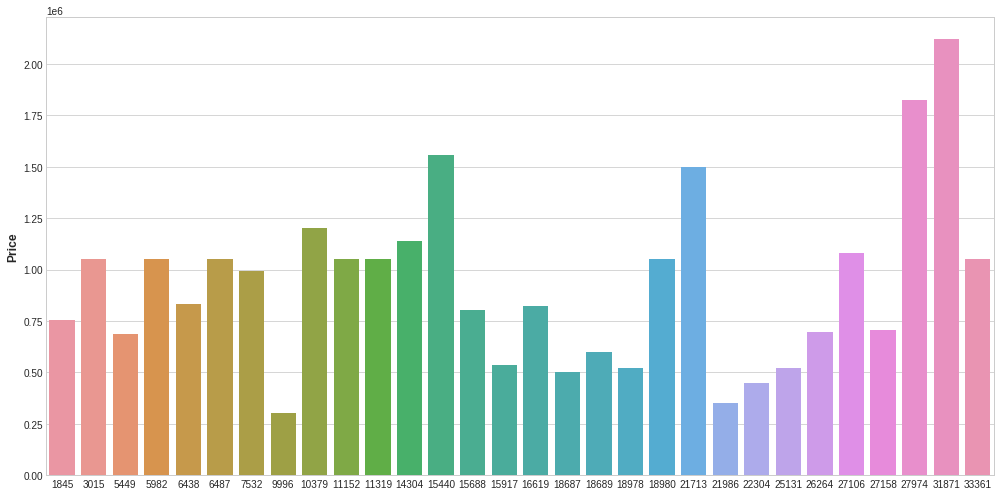

In [ ]:
plt.figure(figsize = (14, 7))
sns.barplot(x = X_view.iloc[:30, :].index, y = y_train[:30])

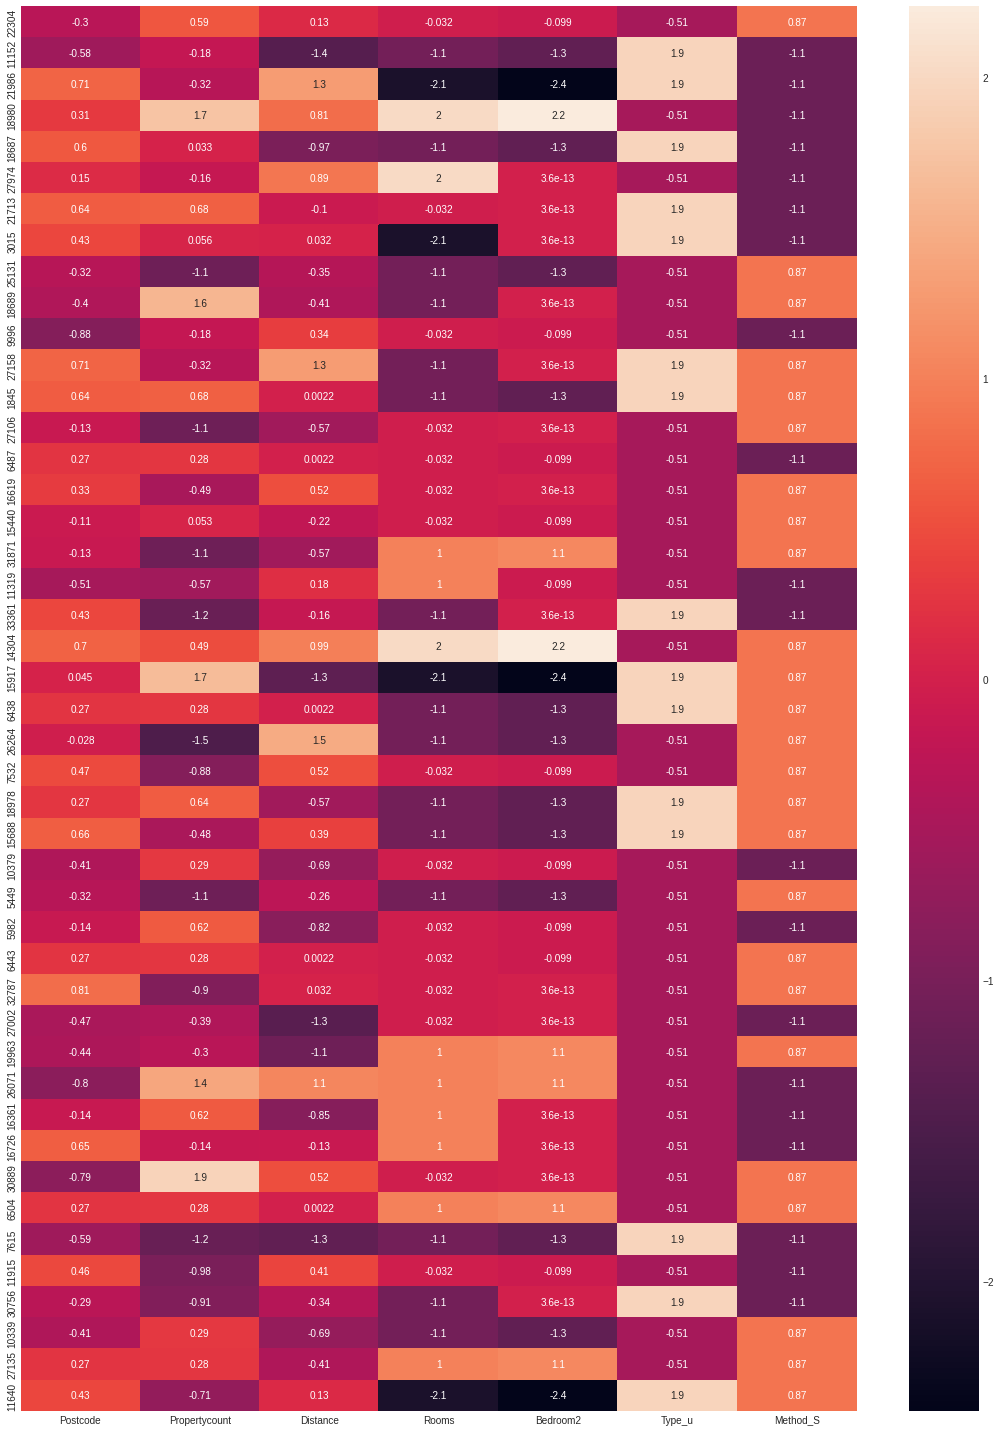

In [ ]:
plt.figure(figsize = (15, 20))
sns.heatmap(data = X_view.iloc[:45, :], annot = True)

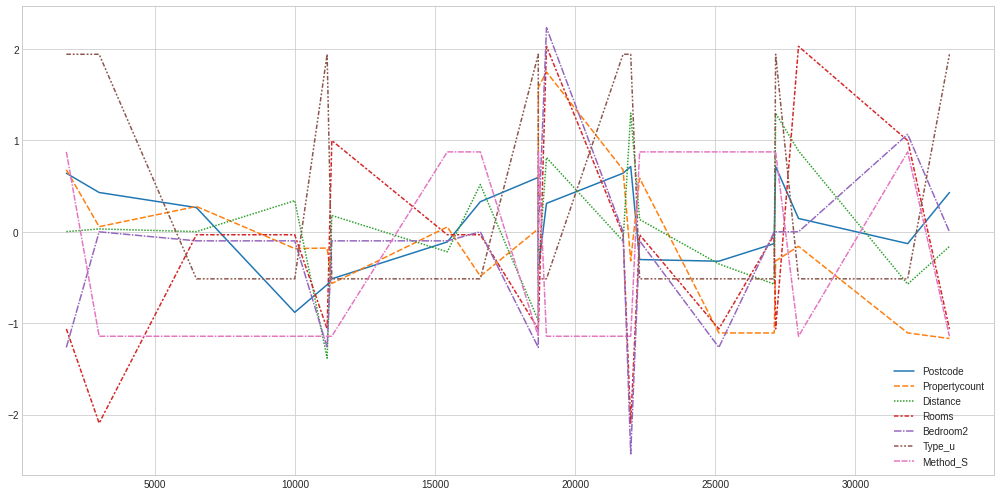

In [ ]:
plt.figure(figsize = (14, 7))
sns.lineplot(data = X_view.iloc[:20, :])

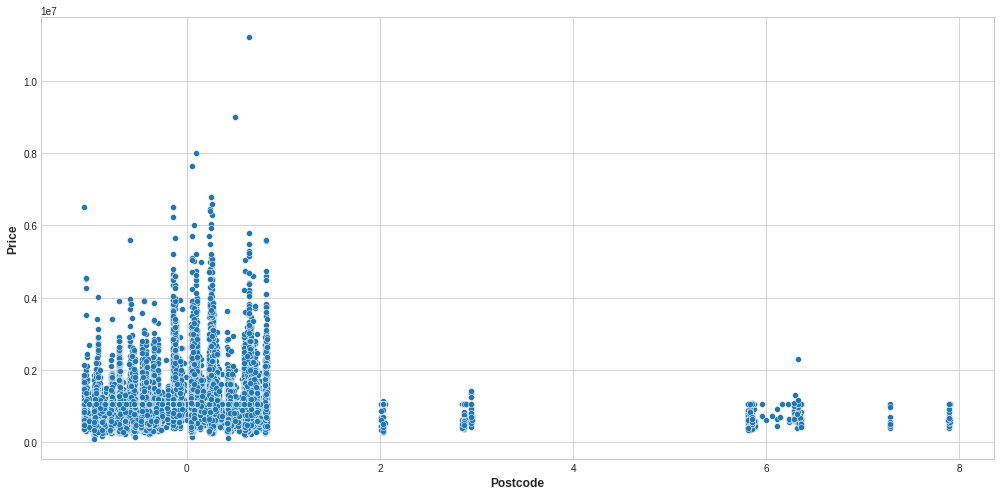

In [ ]:
plt.figure(figsize = (14, 7))
sns.scatterplot(x = X_view["Postcode"], y = y_train)

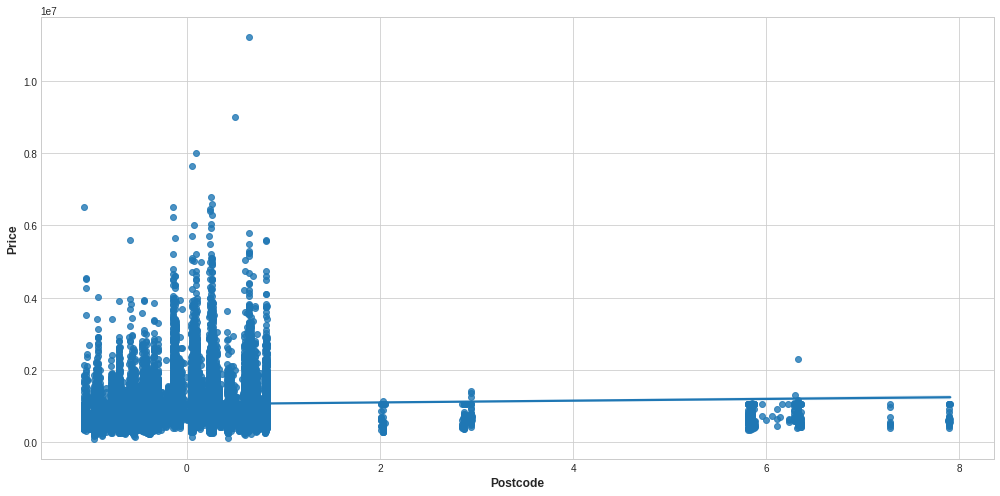

In [ ]:
plt.figure(figsize = (14, 7))
sns.regplot(x = X_view["Postcode"], y = y_train)

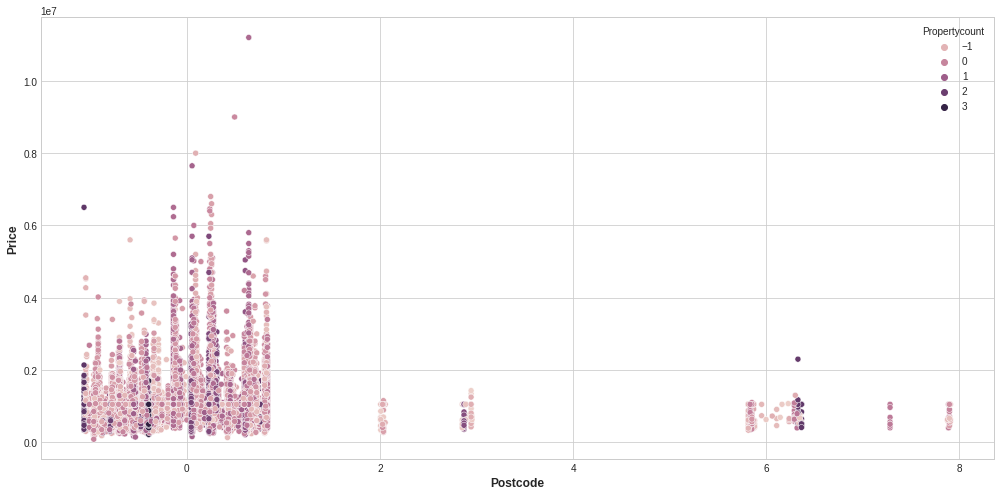

In [ ]:
plt.figure(figsize = (14, 7))
sns.scatterplot(x = X_view["Postcode"], y = y_train, hue = X_view["Propertycount"])

<Figure size 1440x2160 with 0 Axes>

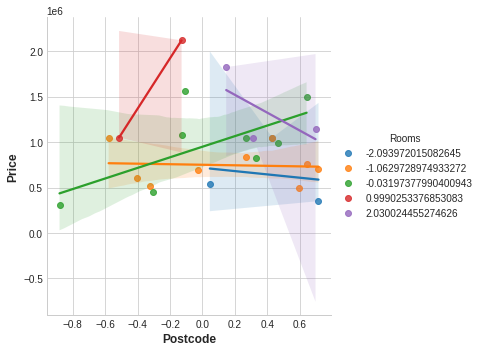

In [ ]:
plt.figure(figsize = (20, 30))
sns.lmplot(x = "Postcode", y = "Price", hue ="Rooms", data = data_view)

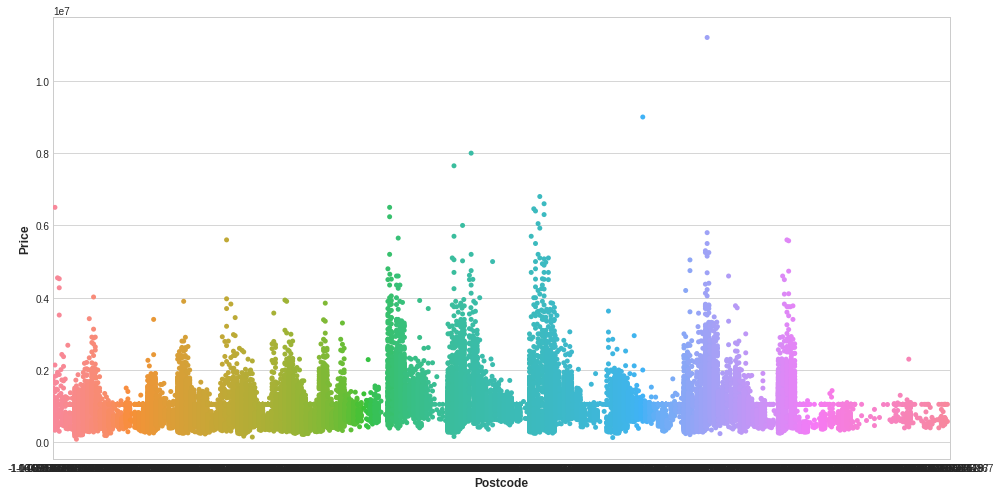

In [ ]:
plt.figure(figsize = (14, 7))
sns.swarmplot(x = X_view["Postcode"], y = y_train)

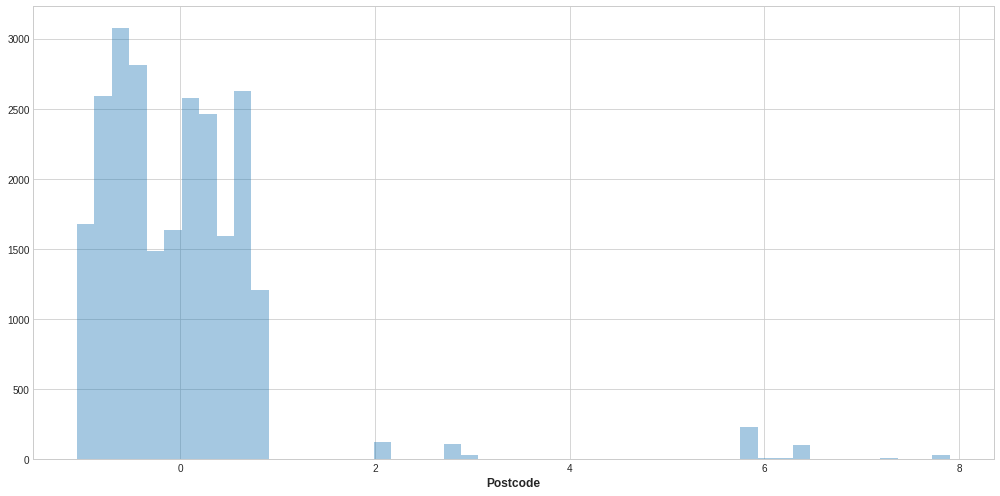

In [ ]:
plt.figure(figsize = (14, 7))
sns.distplot(a = X_view["Postcode"], label = "Postcode", kde=False)

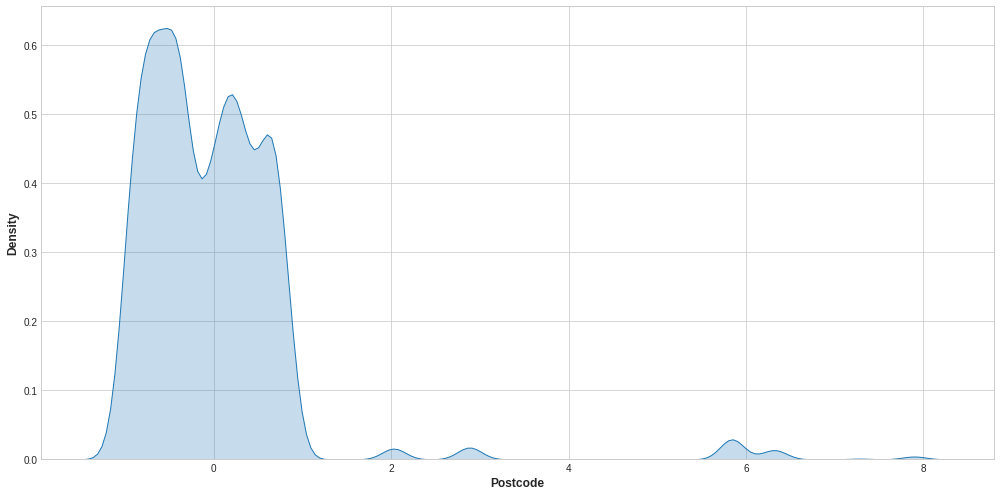

In [ ]:
plt.figure(figsize = (14, 7))
sns.kdeplot(x = X_view["Postcode"], shade = True)

<Figure size 288x288 with 0 Axes>

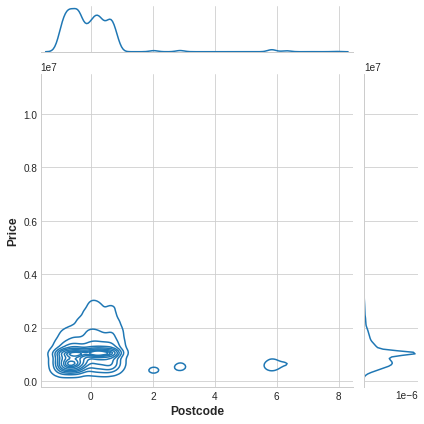

In [ ]:
plt.figure(figsize = (4, 4))
sns.jointplot(x = X_view["Postcode"], y = y_train, kind = "kde")

## **List** **the** **models** **that** **will** **be** **used**

In [ ]:
models = [GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor,
         XGBRegressor, LGBMRegressor]

In [ ]:
selection = model_selection(models, X_train, y_train, X_val, y_val)
selection

,Model Name,Score,Mean_Absolute_Error
2,HistGradientBoostingRegressor,0.57,220792.68
4,LGBMRegressor,0.57,222044.02
3,XGBRegressor,0.55,220782.39
0,GradientBoostingRegressor,0.54,238479.73
1,RandomForestRegressor,0.52,225812.64


**Now we can see the perdormance of each model. 
HistGradientBoostingRegressor is doing well.  
Let's make some predictions**


In [ ]:
mode = HistGradientBoostingRegressor()
M = mode.fit(X_train, y_train)

In [ ]:
mse1 = mean_absolute_error(y_train, M.predict(X_train))
print("Training: ", mse1)

Training:  205772.4273759506


In [ ]:
mse2 = mean_absolute_error(y_val, M.predict(X_val))
print("Testing: ", mse2)

Testing:  220788.06646047713


***Compare to other models , we've achieved some acceptable score
Now it is time to tune our models in order to improve the performance***



---

### We'll define the functions and their repective parameters

In [ ]:
rfr_model = RandomForestRegressor()
rfr_params = {
    "n_estimators" : [600,750,800,850],
    "max_features": [7, 9, 13],
    "min_samples_leaf": [3, 5, 7],
    "min_samples_split": [4, 6, 9],
    "random_state": [10, 31, 50, 100]
    
}

xgb_model = XGBRegressor()
xgb_params = {
    "n_estimators" : [110, 120, 130, 140],
    "learning_rate" : [0.05, 0.075, 0.1],
    "max_depth" : [7, 9, 13],
    "reg_lambda" : [0.3, 0.5, 0.7]
}

HGBR_model = HistGradientBoostingRegressor()
HGBR_params =  {
    'n_estimators': [150, 300, 450, 600],
    'max_depth': [7, 9, 11],
    'min_samples_split': [3, 7, 10],
    'min_samples_leaf': [5, 7, 9],
    'learning_rate': [0.01, 0.02, 0.4, 0.7],
    'max_features': [0.8, 0.7, 0.9],
    'loss': ['ls', 'lad', 'huber']
}

LGBMR_model = LGBMRegressor()
LGBMR_params = {
    "number_leaves" : [10, 31, 50, 100],
    "max_depth": .1,
    "learning_rate" : [0.01, 0.2, 0.5, 0.7],
    "n_estimators" : [50, 100, 150, 200]
}

HGBR_model = HistGradientBoostingRegressor(loss='squared_error',
                                           learning_rate=0.1,
                                           max_iter=100,
                                           max_leaf_nodes=31,
                                           max_depth=None,
                                           min_samples_leaf=20,
                                           l2_regularization=0.0,
                                           max_bins=255,
                                           monotonic_cst=None,
                                           warm_start=False,
                                           early_stopping='auto',
                                           scoring='loss',
                                           validation_fraction=0.1,
                                           n_iter_no_change=10,
                                           tol=1e-07,
                                           verbose=0,
                                           random_state=None)


Now we are defining the tunning function as we must try differents models

In [ ]:
def tunning(model, params, X_t, y_t, X_v, y_v):
    summary = pd.DataFrame([], columns = ["Model Name", "Score", "Mean_Absolute_Error"])

    model_reg = GridSearchCV(estimator = model, param_grid = params, cv=5, n_jobs = -1)
    model_reg.fit(X_t, y_t)
    model_score = model_reg.best_score_
    model_pred = model_reg.predict(X_v)
    mae = mean_absolute_error(y_v, model_pred)
    summary.append({
        "Model Name": model.__class__.__name__ + "tunned",
        "Score": model_score,
        "Mean_Absolute_Error": mae
    }, ignore_index = True)
    print("Best Score: ", model_reg.best_score_)
    print("Best params: ", model_reg.best_params_)
    print("mae: ", mae)
    return summary
    

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 52.8 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 113 kB 51.5 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 149 kB 49.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=71633904b4e55c9ed7a46af7937eed1a1eb4f21f41607247edc8ffb0b6f04b09
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


**Let's use optuna as GridSearch takes a lot of time for processing**

In [ ]:
import optuna

In [ ]:
from sklearn.model_selection import cross_val_score

We are defining a scoring metric

In [ ]:
def score(X, y, model = HistGradientBoostingRegressor()):
  log_y = np.log(y)
  score = cross_val_score(model, X, log_y, cv=5, scoring = "neg_mean_squared_error",)
  score = -1 * score.mean()
  score = np.sqrt(score)
  return score

In [ ]:
score(X_train, y_train)

0.261160248574977

**Optuna use case with HistGradientBoostingRegressor model**

In [ ]:
def objective(trial):

  X_train, X_val, y_train, y_val = load_data(target_col, random_state, test_size)

  HGBR_params = dict(loss = trial.suggest_categorical("loss", 'least_squares'),
                    learning_rate = trial.suggest_float("learning_rate", 0.2, 0.4),
                    max_iter= trial.suggest_int("max_iter", 100, 200, 300),
                    max_leaf_nodes= trial.suggest_int("max_leaf_nodes", 15, 31, 60), 
                    max_depth= trial.suggest_int("max_depth" , 7, 9, 15),
                    min_samples_leaf=trial.suggest_int("min_samples_leaf", 20, 50, 80),
                    l2_regularization= trial.suggest_float("l2_regularization", 0.3, 0.7),                                           scoring='loss',
                    tol = trial.suggest_float("tol", 1e-05, 1e-02)
                  )
  
  HGBR_t = HistGradientBoostingRegressor(**HGBR_params)
  log_y = np.log(y_train)
  score = cross_val_score(HistGradientBoostingRegressor(), X_train,from sklearn.model_selection import RepeatedKFold
  score = -1 * score.mean()
  score = np.sqrt(score)
  return score

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)
HGBR_params = study.best_params

[I 2022-02-20 16:22:38,854] A new study created in memory with name: no-name-d8cfd5b2-6fdb-477d-a4d0-4ff9d46586e0
[I 2022-02-20 16:22:54,411] Trial 0 finished with value: 0.26094750371416503 and parameters: {'loss': 'e', 'learning_rate': 0.26718154442575537, 'max_iter': 100, 'max_leaf_nodes': 15, 'max_depth': 7, 'min_samples_leaf': 20, 'l2_regularization': 0.5531584572542916, 'tol': 0.00810442120397995}. Best is trial 0 with value: 0.26094750371416503.
[I 2022-02-20 16:23:04,443] Trial 1 finished with value: 0.26160121248093215 and parameters: {'loss': 's', 'learning_rate': 0.3879613202609276, 'max_iter': 100, 'max_leaf_nodes': 15, 'max_depth': 7, 'min_samples_leaf': 20, 'l2_regularization': 0.3649824076132553, 'tol': 0.0013311792673320743}. Best is trial 0 with value: 0.26094750371416503.
[I 2022-02-20 16:23:14,277] Trial 2 finished with value: 0.2612094369405759 and parameters: {'loss': '_', 'learning_rate': 0.3907577882916993, 'max_iter': 100, 'max_leaf_nodes': 15, 'max_depth': 7, '

**We've got the best parameters of our model that we can use for future tests**

In [ ]:
HGBRmode = LGBMRegressor(**HGBR_params)

**Just in case you need to know about sklearn metrics**

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

**Optuna use case for LGBMRegressor model**

In [ ]:
def objective(trial):case
  LGBMR_params = dict(
    number_leaves = trial.suggest_int("number_leaves",15, 60, 80),
    max_depth = trial.suggest_int("max_depth", 7, 9, 14),
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.7),
    n_estimators = trial.suggest_int("n_estimators", 25, 45, 75),
  )
  LGBM_t = LGBMRegressor(**LGBMR_params)
  return score(X_train, y_train, LGBM_t)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 20)
LGBMR_params = study.best_params


[I 2022-02-20 15:57:04,237] A new study created in memory with name: no-name-c9e5b56e-9b59-40a3-9f5e-c10de11c8d59
[I 2022-02-20 15:57:11,064] Trial 0 finished with value: 0.26882308233722885 and parameters: {'number_leaves': 15, 'max_depth': 7, 'learning_rate': 0.5691204997786115, 'n_estimators': 25}. Best is trial 0 with value: 0.26882308233722885.
[I 2022-02-20 15:57:12,587] Trial 1 finished with value: 0.2646344402114728 and parameters: {'number_leaves': 15, 'max_depth': 7, 'learning_rate': 0.2842207931364401, 'n_estimators': 25}. Best is trial 1 with value: 0.2646344402114728.
[I 2022-02-20 15:57:14,025] Trial 2 finished with value: 0.2703507537412992 and parameters: {'number_leaves': 15, 'max_depth': 7, 'learning_rate': 0.6690403240641951, 'n_estimators': 25}. Best is trial 1 with value: 0.2646344402114728.
[I 2022-02-20 15:57:15,744] Trial 3 finished with value: 0.3182005893254357 and parameters: {'number_leaves': 15, 'max_depth': 7, 'learning_rate': 0.04308955014408046, 'n_estim

In [ ]:
LGBMfinal = LGBMRegressor(**LGBMR_params)

In [ ]:
LGBMfinal.fit(X_train, np.log(y_train))

LGBMRegressor(learning_rate=0.5054666392659258, max_depth=10, n_estimators=30,
              number_leaves=50)

In [ ]:
mean_absolute_error(y_val, np.exp(LGBMfinal.predict(X_val)))

215745.48819679674

Tunning Done ▶
It's time to verify if we've done some remarkable work

**We've slightly made impeovements but we can keep trying to change the params provided to optuna**

In [ ]:
mse1 = mean_absolute_error(y_train, np.exp(LGBMfinal.predict(X_train)))
print("Training: ", mse1)

Training:  200579.30003465695


In [ ]:
mse2 = mean_absolute_error(y_val, np.exp(LGBMfinal.predict(X_val)))
print("Testing: ", mse2)

Testing:  215745.48819679674
